# DTSA 5509: Beer ML Project

## Project Overview

For this project, I will be analyzing the public Beer Profile Ratings Data Set from Kaggle (linked below). The goal of this project will be to create a classification model that accurately predicts the type/style of beer based on  some of its characteristics. My intial thought is to utilize an Ensemble/Random Forrest model or a Support Vector Classifier; however; I will test additional models as needed depednding upon accuracy.

In [192]:
#Importing Libraries and Packages
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import requests
from io import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


## Beer Profile Ratings Data Set

As previosly mentioned, the dataset for this project was found from Kaggle and includes a variety of attributes about various beers. In ther dataset, there are roughly 3200 beers included, and some key featurs of the beers are: Style, ABV, Alcohol, Taste, and Flavor. After cleaning, I expect to use 'Style' as the response, and there will be 19 predictors that can be tested/used in the model.

Beer profile and ratings data set. Kaggle. (2021, November 18). https://www.kaggle.com/datasets/ruthgn/beer-profile-and-ratings-data-set/data

In [94]:
#Reading in Dataframe from project github repository
url = 'https://raw.githubusercontent.com/JSchlangen9/ML-Beer/main/beer_profile_and_ratings.csv'
file = requests.get(url)
string_data = StringIO(file.text)

df = pd.read_csv(string_data)

df.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,33,57,8,111,3.498994,3.636821,3.556338,3.643863,3.847082,497
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,24,35,12,84,3.798337,3.846154,3.904366,4.024948,4.034304,481
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,10,54,4,62,3.409814,3.667109,3.600796,3.631300,3.830239,377
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,49,40,16,119,4.148098,4.033967,4.150815,4.205163,4.005435,368
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,11,51,20,95,3.625000,3.973958,3.734375,3.765625,3.817708,96


## Data Cleaning

Initial data cleaning will consist of removing unneeded columns and searching for null/missing/incorrect values in attribute columns. Columns that are not needed for the column include items such as 'Description' and 'Brewery'. Individual samples appear to be clean, and there were not any null values in the dataset. Records with a 'Max IBU' value equal to 0 were removed, because this most likely corresponds to a null value in that sample. This resulted in removing 100 records from the dataset.

Additionally, I manually reclassified the beers to broader categories for purposes of the classification model that I am trying to build. For example, I am not interested in classifying a beer as a 'Mexican Lager', but I am interested in correctly classifying the beer as a 'Lager'. After reclassifying beers into 10 common categories, another 589 records were removed from the dataset, resulting in 2,480 records remaining.

A challenge that I discovered during the data cleaning process was the presence of values equalling 0 that were completely legitimate. In many datasets, records with a 0 value can be excluded because they are either incorrect or highly improbable. With that said, due to the range of beer styles, many of these values could legitimately be 0, and that poses a risk to the validity of the analysis.

In [95]:
#Dropping unnedded columns and removing Max IBU values == 0
df = df.drop(['Name', 'Brewery', 'Beer Name (Full)', 'Description'], axis=1)
df = df[df['Max IBU'] > 0]

#Manually Classifying Beer into 10 common categories and removing other records
beer_categories = ['Ale', 'Bock', 'Bitter', 'IPA', 'Lager', 'Pilsner', 'Porter', 'Sour', 'Stout', 'Wheat Beer']

for cat in beer_categories:
    df.loc[df['Style'].str.contains(cat), 'Style'] = cat

df = df[df['Style'].isin(beer_categories)]

df.describe()

,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,review_aroma,review_appearance,review_palate,review_taste,review_overall,number_of_reviews
count,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000,2480.000000
mean,6.483593,22.517339,39.804032,16.786290,48.872581,16.156048,39.918548,56.645161,30.730645,1.056048,35.225806,43.558871,15.636694,80.054839,3.612744,3.753474,3.650307,3.691706,3.750649,243.394758
std,2.434846,12.201701,19.875863,9.861091,26.730648,16.187618,25.902488,31.060974,32.486036,2.227230,30.074625,30.340008,18.593675,38.702382,0.503906,0.403362,0.441199,0.503283,0.429636,370.835830
min,0.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.509615,1.827916,1.682692,1.355769,1.471154,1.000000
25%,5.000000,15.000000,25.000000,10.000000,30.000000,6.000000,20.000000,33.000000,10.000000,0.000000,11.000000,21.000000,4.000000,50.000000,3.386364,3.605110,3.462121,3.476605,3.571337,27.000000
50%,5.800000,20.000000,35.000000,15.000000,42.000000,11.000000,35.000000,53.000000,20.000000,0.000000,26.000000,36.000000,10.000000,77.500000,3.693650,3.833333,3.728772,3.782763,3.833333,100.000000
75%,7.500000,25.000000,45.000000,22.000000,61.000000,20.000000,56.000000,74.000000,40.000000,1.000000,54.000000,58.000000,20.000000,107.000000,3.958333,4.000000,3.951476,4.017862,4.029978,296.250000
max,57.500000,65.000000,100.000000,77.000000,175.000000,126.000000,150.000000,217.000000,238.000000,48.000000,175.000000,172.000000,173.000000,239.000000,4.750000,4.625000,4.666667,5.000000,4.807692,3290.000000


## Exploratory Data Analysis

As shown by the violin plot, the flavor attributes largely appear to be normally distributed; however there are long tails in the positive for certain attributes. For example, the 'Sour' attribute has a large positive tail due to the fact that this is a 'Style' of beer, as well as the 'Bitter' attribute which tends to be associated with IPA's and other flavorful beers.

After analyzing the review attributes, these do not appear to be helpful in the classification of the style of a beer. Review scores are largely independent of the style of beer, and therefore, these predictors are more likely to confuse the model. As a result, they will be removed from the pool of predictors that will be used to classify the beers.

According to the correlation heatmaps, I observed some strong correlations which make sense given domain knowledge. For example, there is a strong correlation between 'Body' and 'Malty' attributes, as well as 'Bitter' and 'Hoppy' attributes. This is exciting to see because hops tend to give beer a bitter flavor, and body/malty traits are somewhat synonymous as well.

<Axes: >

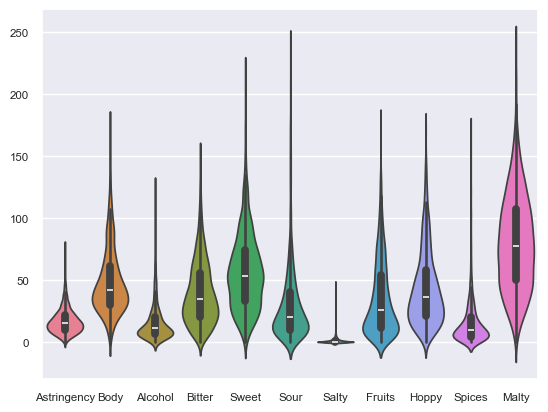

In [112]:
#Creating Violin Plot for Flavor Attributes
flavor_df = df[['Astringency', 'Body', 'Alcohol', 'Bitter', 'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty']]

sns.set_theme(font_scale=0.75)
sns.violinplot(flavor_df)

<Axes: >

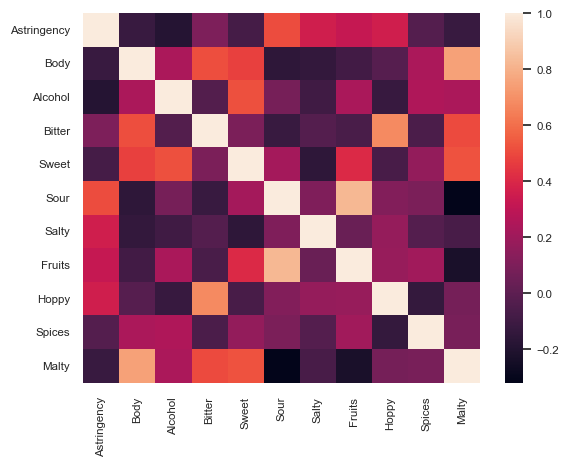

In [127]:
#Creating Correlation Heatmap for Flavor Attributes
sns.heatmap(flavor_df.corr())

<Axes: >

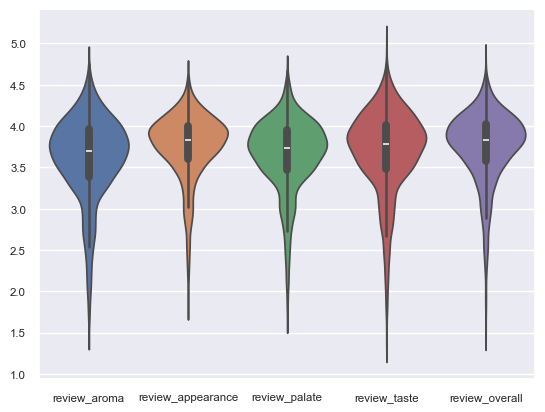

In [113]:
#Creating Violin Plot for Review Attributes
review_df = df[['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'review_overall']]

sns.set_theme(font_scale=0.75)
sns.violinplot(review_df)

<Axes: >

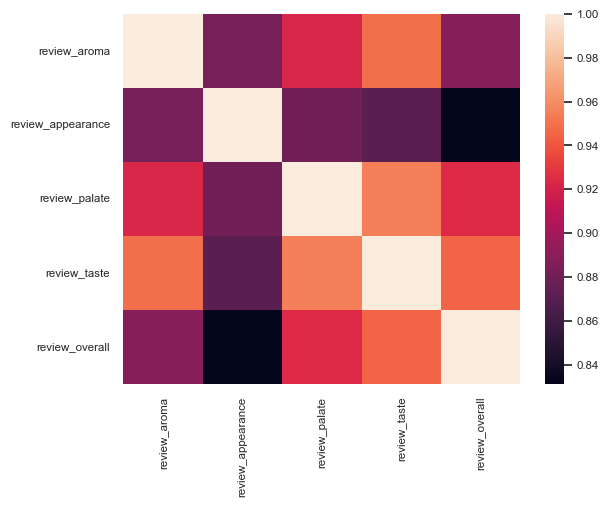

In [115]:
#Creating Correlation Heatmap for Review Attributes
sns.heatmap(review_df.corr())

## Model Testing & Selection

I initially tested base models using the support vector classifier and random forest packages without adjusting hyperparameters. By doing this, I quickly identified that the random forest model was better suited for the task at hand, and would proceed with diving deeper into the random forest model.

Through testing and iteration, I adjusted the hyperparameters for number of estimators, and the number of features to be included in the model. By doing this, I observed an average 2% increase in the performance of the model, and the random forest model is roughly 85% accurate.

As shown in the feature importance plot, the 3 most imprtant features in the model are 'Min IBU', 'Max IBU', and 'Body'. This ties back to observations from the exploratory data analysis, as well as my domain knowledge. International Bitterness Unit (IBU) is largely a measure of a beers hoppiness/bitterness, and Body is one of the strongest defining characteristics of a beers taste/profile. 

In [202]:
#Creating Training & Testing Splits
x = np.array(df.drop(['Style', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'review_overall', 'number_of_reviews'], axis=1))
y = np.array(df['Style'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#Building Random Forest & Support Vector Classificiation Models
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

sv = SVC()
sv.fit(x_train, y_train)

#Testing Model Accuracy
rf_acc = accuracy_score(y_test, rf.predict(x_test))
sv_acc = accuracy_score(y_test, sv.predict(x_test))

print('Random Forest Accuracy:', rf_acc)
print('Support Vector Accuracy:', sv_acc)

Random Forest Accuracy: 0.8225806451612904
Support Vector Accuracy: 0.6733870967741935


In [203]:
#Building Robust Random Forest Model with adjusted hyperparameters
model = RandomForestClassifier(n_estimators=999, max_features=5)
model.fit(x_train, y_train)

model_acc = accuracy_score(y_test, model.predict(x_test))

print('Random Forest (Tuned) Accuracy:', model_acc)

Random Forest (Tuned) Accuracy: 0.8306451612903226


<Axes: title={'center': 'Feature Importance'}, ylabel='Impurity Decrease'>

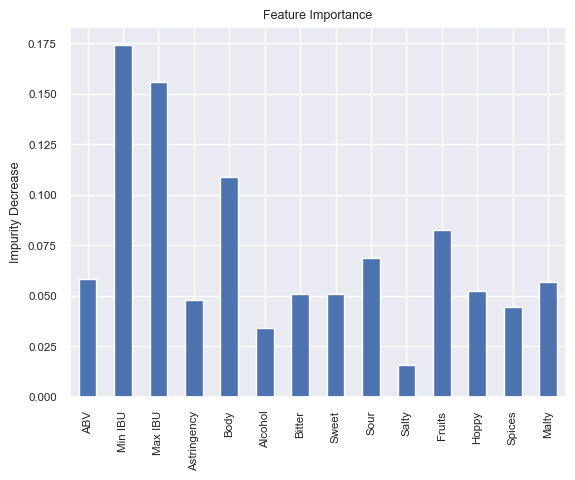

In [201]:
#Plotting Feature Importance
imp = model.feature_importances_
feat = df.drop(['Style', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'review_overall', 'number_of_reviews'], axis=1).columns.unique().tolist()

model_imp = pd.Series(imp, index=feat)

model_imp.plot.bar(title='Feature Importance', ylabel='Impurity Decrease')

## Results & Conclusion

In terms of results, I am very satisified with the random forest classification model that I built, and the scores/metrics calculated are in agreement with that claim. Accuracy topped out at roughly 85%, while completeness and homegeneity scores were 73% and 72% respectively. The lower completeness and homegeneity scores tell me that beer styles tend to exist on a spectrum, and that the lines between categories are often blurred. For these reasons, a classification model with 10 different choices and 85% accuracy is incredible.

The display of the confusion matrix shows 2 things clearly: Ale/Lager are the most popular types of beer in the dataset, and Bock is the most incorrectly classified style of beer. The model did quite well at distinguishing Ales and Lagers; however, it struggled with the Bock style which can often be described as similar to an Ale or a dark Lager. Again, the accuracy score wil show this case as an incorrect prediction, when in the real world it could be considered subjectively correct.

For future testing, I would find it valuable to narrow down the number of beer styles that a model would try to predict. As previously mentioned, the model that I built classified a beer into 1 of 10 categories, which is very difficult to do when beers exist on a spectrum of styles. A model could be built with higher accuracy if it only had to fit beers into a group of 5 or less categories.

In [198]:
#Calculating Model Accuracy, Completeness, & Homogeneity Scores
model_comp = completeness_score(y_test, model.predict(x_test))
model_hom = homogeneity_score(y_test, model.predict(x_test))

print('Random Forest (Tuned) Accuracy:', model_acc)
print('Random Forest (Tuned) Completeness:', model_comp)
print('Random Forest (Tuned) Homegeneity:', model_hom)

Random Forest (Tuned) Accuracy: 0.8508064516129032
Random Forest (Tuned) Completeness: 0.7252881399527635
Random Forest (Tuned) Homegeneity: 0.7184997692400054


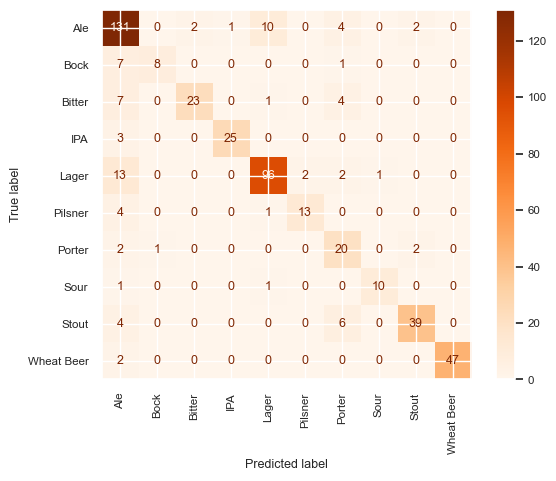

In [212]:
#Plotting Model Confusion Matrix
model_cm = confusion_matrix(y_test, model.predict(x_test))
model_disp = ConfusionMatrixDisplay(model_cm, display_labels=beer_categories)

model_disp.plot(cmap='Oranges', xticks_rotation='vertical')
plt.show()